In [6]:
# Packages for model learning
import numpy as np
import sklearn.metrics
import pandas as pd
import sklearn.model_selection

import torch
import torchvision
import gpytorch
import botorch

# Packages for data loading
import json
from pathlib import Path

In [7]:
# Packages for Jupyter notebook
import IPython.display as ipd
import matplotlib.pyplot as plt
import PIL
import base64

In [8]:
from functools import cache

tensor_to_image = torchvision.transforms.ToPILImage()
@cache
def tensor_to_url(tensor, size=128):
    return fr"data:image/png;base64,{base64.b64encode(PIL.ImageOps.contain(tensor_to_image(tensor), (size, size))._repr_png_()).decode('ascii')}"

# Load and process data

In [9]:
## Make all photos square
def pad_image(img):
    h,w = img.shape[1:]
    if h != w:
        new_w = max(h,w)
        pad_h, rem_h = divmod(new_w - h, 2)
        pad_w, rem_w = divmod(new_w - w, 2)
        padding = [pad_w, pad_h, pad_w+rem_w, pad_h+rem_h]
        return torchvision.transforms.functional.pad(img, padding, padding_mode='edge')
    return img

In [22]:
# Load dataset

# img_root = './dataset/dress_pure_renamed/'
# train_metadata = json.loads(Path('./dataset/dress_pure_renamed/train.json').read_text())
# test_metadata = json.loads(Path('./dataset/dress_pure_renamed/test.json').read_text())
# val_metadata = json.loads(Path('./dataset/dress_pure_renamed/val.json').read_text())

# class_labels = ['christian_dior', 'maison_margiela']
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

# img_root = Path('./dataset/')
img_root = Path('F://datasets//fashion_designers_list')
train_metadata = json.loads((img_root / 'train.json').read_text())
test_metadata = json.loads((img_root / 'test.json').read_text())
val_metadata = json.loads((img_root / 'val.json').read_text())

# class_labels = ["alexander_mcqueen","donatella_versace","karl_lagerfeld","yves_saint_laurent"]
class_labels = ["alexander_mcqueen", "donatella_versace", "john_galliano", "karl_lagerfeld", "yves_saint_laurent"]
class_labels = [x.replace('_',' ') for x in class_labels]

n_train = len(train_metadata)
n_test = len(test_metadata)
n_val = len(val_metadata)
n_all = n_train + n_test + n_val

all_classes = torch.empty(n_all, dtype=torch.int)
all_images = [None]*n_all
for i,meta in enumerate((*train_metadata, *test_metadata, *val_metadata)):
    all_classes[i] = meta['label']
    all_images[i] = torchvision.io.read_image(str(img_root / meta['file_path'].replace('_pure',''))).to(device)
    all_images[i] = pad_image(torchvision.transforms.functional.resize(all_images[i], 512, antialias=True)).to(device)

In [23]:
n_classes = all_classes.max() + 1

In [24]:
from resnet_model import resnet_model

In [28]:
resnet_extractor = resnet_model(n_classes,backbone="resnet18")
resnet_extractor.to(device)
checkpoint = torch.load('results//fashion_designers_c5.3layer.bsz_128sz_224.sgd0.002//best_model.pt', map_location=device)
resnet_extractor.load_state_dict(checkpoint['state_dict'])

e:\Users\nora\anaconda3\envs\deep_gp\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Users\nora\anaconda3\envs\deep_gp\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [29]:
for p in resnet_extractor.parameters():
    p.requires_grad = False

In [30]:
# Define resnet feature extractor
resnet_input_transform = torchvision.models.ResNet18_Weights.DEFAULT.transforms()
crop_size = resnet_input_transform.crop_size[0]

all_data = torch.empty(n_all, 3, crop_size, crop_size).to(device)
for i in range(n_all):
    all_data[i] = resnet_input_transform(all_images[i])

e:\Users\nora\anaconda3\envs\deep_gp\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [31]:
all_embeddings = resnet_extractor.backbone(all_data)

# Split train/test

In [32]:
kfold = sklearn.model_selection.ShuffleSplit(n_splits=1, random_state=19960111)
train_idx, test_idx = next(kfold.split(np.empty(len(all_classes)), all_classes))

In [33]:
train_classes = all_classes[train_idx]
train_embeddings = all_embeddings[train_idx]

test_classes = all_classes[test_idx]
test_embeddings = all_embeddings[test_idx]

In [34]:
train_dataset = torch.utils.data.TensorDataset(train_embeddings, torch.arange(len(train_embeddings)))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)

# Init Wandb

In [35]:
import wandb
wandb.init(
    project="fashion-design-analysis",
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: meimeimei (fashion_gp). Use `wandb login --relogin` to force relogin


# Define and train GP

In [36]:
class DirichletGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, num_inducing, num_classes, input_dim, latent_dim):
        self.batch_shape = torch.Size([num_classes])
        self.inducing_inputs = torch.randn(num_classes, num_inducing, latent_dim)
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(num_inducing, batch_shape=self.batch_shape)
        variational_strategy = gpytorch.variational.VariationalStrategy(self, self.inducing_inputs, variational_distribution, learn_inducing_locations=True)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=self.batch_shape)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(),
            batch_shape=self.batch_shape,
        )
        self.scaler = gpytorch.utils.grid.ScaleToBounds(-1,1)
        self.fc = torch.nn.Linear(input_dim,latent_dim)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def transform(self, x):
        x = self.fc(x)
        x = self.scaler(x)
        return x

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def __call__(self, inputs, prior: bool = False, **kwargs):
        if inputs is not None and inputs.dim() == 1:
            inputs = inputs.unsqueeze(-1)
        if inputs is not None:
            inputs = self.transform(inputs)
        return self.variational_strategy(inputs, prior=prior, **kwargs)

    def embedding_posterior(self, z):
        '''Compute the posterior over z = self.transform(x)'''
        return self.variational_strategy(z, prior=False)

In [37]:
class MinibatchedDirichletClassificationLikelihood(gpytorch.likelihoods.DirichletClassificationLikelihood):
    def _shaped_noise_covar(self, base_shape, *params, selected_noise=None, **kwargs):
        assert selected_noise is not None
        if len(params) > 0:
            # we can infer the shape from the params
            shape = None
        else:
            # here shape[:-1] is the batch shape requested, and shape[-1] is `n`, the number of points
            shape = base_shape

        res = self.noise_covar(*params, shape=shape, noise=selected_noise, **kwargs)

        if self.second_noise_covar is not None:
            res = res + self.second_noise_covar(*params, shape=shape, **kwargs)
        elif isinstance(res, gpytorch.linear_operator.ZeroLinearOperator):
            warnings.warn(
                "You have passed data through a FixedNoiseGaussianLikelihood that did not match the size "
                "of the fixed noise, *and* you did not specify noise. This is treated as a no-op.",
                gpytorch.utils.warnings.GPInputWarning,
            )

        return res

In [39]:
likelihood = MinibatchedDirichletClassificationLikelihood(train_classes.long(), learn_additional_noise=True).to(device)
# likelihood = gpytorch.likelihoods.DirichletClassificationLikelihood(train_classes.long(), learn_additional_noise=True)

train_transformed_targets = likelihood.transformed_targets

In [50]:
torch.manual_seed(0)
model = DirichletGPModel(
    num_inducing=300,
    input_dim=train_embeddings.shape[1],
    num_classes=likelihood.num_classes,
    latent_dim=5
)
model = model.to(device)
# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_classes.size(0)).to(device)
mll.train();

In [51]:
optimization_trace = []
num_epochs = 100
optimizer = torch.optim.Adam(mll.parameters(), lr=0.01)
step = 0
for i in range(num_epochs):
    # print(i+1, num_epochs)
    for x_batch, x_idx_batch in train_loader:
        y_batch = train_transformed_targets[:,x_idx_batch]
        y_batch = y_batch.to(device)
        noise_batch = likelihood.noise_covar.noise[:, x_idx_batch]
        optimizer.zero_grad()
        output = model(x_batch)
        full_loss = -mll(output, y_batch, selected_noise=noise_batch)
        with torch.no_grad():
            wandb.log({
                'loss': full_loss.mean(dim=0).item(),
                'full_loss': wandb.Histogram(full_loss.numpy(force=True)),
                'hyper/lengthscale': wandb.Histogram(model.covar_module.base_kernel.lengthscale.view(-1).numpy(force=True)),
                'hyper/outputscale': wandb.Histogram(model.covar_module.outputscale.numpy(force=True)),
                'hyper/second_noise': wandb.Histogram(likelihood.second_noise.view(-1).numpy(force=True)),
                'hyper/fc_eighs': torch.linalg.eigvalsh(model.fc.weight.T @ model.fc.weight).sum().item(),
            }, step=step)
        loss = full_loss.mean(dim=0)
        optimization_trace.append(full_loss.mean(dim=0).item())
        loss.backward()
        optimizer.step()
        step += 1

wandb: WARNING Step only supports monotonically increasing values, use define_metric to set a custom x axis. For details see: https://wandb.me/define-metric
wandb: WARNING (User provided step: 0 is less than current step: 299. Dropping entry: {'loss': 4.790029048919678, 'full_loss': {'_type': 'histogram', 'values': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1], 'bins': [4.075298309326172, 4.092454433441162, 4.109610080718994, 4.126766204833984, 4.143921852111816, 4.161077976226807, 4.178234100341797, 4.195389747619629, 4.212545871734619, 4.229701519012451, 4.246857643127441, 4.264013767242432, 4.281169414520264, 4.298325538635254, 4.315481185913086, 4.332637310028076, 4.349793434143066, 4.366949081420898, 4.384105205535889, 4.401260852813721, 4.418416976928711, 4.435572624206543, 4.452728748321533, 4.469884872436523, 4.4870405197143555, 4.50

wandb: WARNING (User provided step: 259 is less than current step: 299. Dropping entry: {'loss': 2.1342837810516357, 'full_loss': {'_type': 'histogram', 'values': [1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'bins': [2.099930763244629, 2.101686954498291, 2.103443145751953, 2.105199098587036, 2.1069552898406982, 2.1087114810943604, 2.1104674339294434, 2.1122236251831055, 2.1139798164367676, 2.1157360076904297, 2.117492198944092, 2.119248151779175, 2.121004343032837, 2.122760534286499, 2.124516487121582, 2.126272678375244, 2.1280288696289062, 2.1297850608825684, 2.1315412521362305, 2.1332972049713135, 2.1350533962249756, 2.1368095874786377, 2.1385655403137207, 2.140321731567383, 2.142077922821045, 2.143834114074707, 2.145590305328369, 2.147346258163452, 2.1491024494171143, 2.1508586406707764, 2.1526145935058594, 2.1543707847595215, 2.1561269

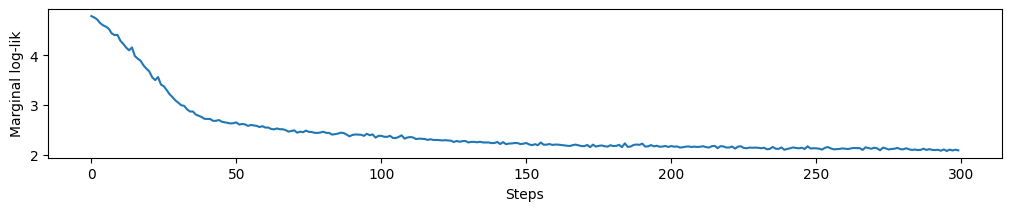

In [52]:
f,ax = plt.subplots(1,1,constrained_layout=True,figsize=(10,2*1), sharex=True)
ax.plot(optimization_trace)
ax.set_ylabel('Marginal log-lik');
ax.set_xlabel('Steps');
plt.show(f);plt.close(f)

## Metrics

In [53]:
metrics = pd.Series(index=['acc','auc'])

In [54]:
test_dataset = torch.utils.data.TensorDataset(test_embeddings, test_classes)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [55]:
n_plots = 1
n_cols = 5
n_rows = int(np.ceil(n_plots / n_cols))

model.eval()
test_pred_classes = torch.empty(len(test_classes), dtype=torch.int64)
test_pred_probabilities = torch.empty(n_classes, len(test_classes), dtype=torch.float32)
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(test_loader):
        j = (i*test_loader.batch_size)
        test_pred_dist = model(x_batch)

        test_pred_samples = test_pred_dist.sample(torch.Size((256,))).exp()
        test_probabilities = (test_pred_samples / test_pred_samples.sum(1, keepdim=True)).mean(0)
        test_pred_classes[j:j+len(x_batch)] = torch.argmax(test_probabilities,dim=0,keepdim=False)
        test_pred_probabilities[:,j:j+len(x_batch)] = test_probabilities

acc = sklearn.metrics.accuracy_score(test_classes, test_pred_classes)
auc = sklearn.metrics.roc_auc_score(test_classes,test_pred_probabilities.T,multi_class="ovo")
metrics.at['acc'] = acc
metrics.at['auc'] = auc
display(metrics)

acc    0.785978
auc    0.899068
dtype: float64